In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import yt
import cv2 as cv  
import scipy.ndimage as ndimage  # for 3D morphological operations
from matplotlib import colors

DEBUG = True
hdf5_prefix = 'sn34_smd132_bx5_pe300_hdf5_plt_cnt_0'

def load_mask_cube(mask_root, timestamp, cube_dim=256):
    """
    Step 1: Read the input 3D cube of binary masks.
    Assumes files are stored in: mask_root/timestamp and named as <slice_index>.png.
    """
    mask_dir = os.path.join(mask_root, timestamp)
    mask_cube = np.zeros((cube_dim, cube_dim, cube_dim), dtype=np.uint8)
    
    for file_name in sorted(os.listdir(mask_dir)):
        if file_name.endswith('.png'):
            slice_index = int(os.path.splitext(file_name)[0])
            if slice_index < cube_dim:
                file_path = os.path.join(mask_dir, file_name)
                mask_slice = cv.imread(file_path, cv.IMREAD_GRAYSCALE)
                if mask_slice is None:
                    raise ValueError(f"Failed to read {file_path}")
                mask_cube[:, :, slice_index] = mask_slice
    return mask_cube

def load_temperature_cube(hdf5_root, timestamp, hdf5_prefix, pixel_boundary, lower_bound, upper_bound):
    """
    Step 2: Read HDF5 raw data and extract temperature values for the center cube.
    """
    hdf5_file = os.path.join(hdf5_root, f'{hdf5_prefix}{timestamp}')
    ds = yt.load(hdf5_file)
    
    # Define center (here simply the origin in code units)
    arb_center = ds.arr([0, 0, 0], 'code_length')
    left_edge = arb_center + ds.quan(-500, 'pc')
    right_edge = arb_center + ds.quan(500, 'pc')
    
    # Create an arbitrary grid of desired resolution
    grid = ds.arbitrary_grid(left_edge, right_edge, dims=(pixel_boundary, pixel_boundary, pixel_boundary))
    
    # Extract the temperature cube from the arbitrary grid and convert to Kelvin
    temp_cube = grid[("flash", "temp")][
        lower_bound:upper_bound,
        lower_bound:upper_bound,
        lower_bound:upper_bound
    ].to('K').value
    return temp_cube

def spherical_kernel(kernel_size):
    """
    Creates a 3D spherical structuring element with the given size.
    The sphere's radius is (size - 1)/2.
    """
    center = (np.array([kernel_size, kernel_size, kernel_size]) - 1) / 2.0
    x, y, z = np.indices((kernel_size, kernel_size, kernel_size))
    kernel = ((x - center[0])**2 + (y - center[1])**2 + (z - center[2])**2) <= (center[0]**2)
    return kernel.astype(np.uint8)

In [2]:
hdf5_root = "/srv/data/stratbox_simulations/stratbox_particle_runs/bx5/smd132/sn34/pe300/4pc_resume/4pc"
mask_root = '/home/joy0921/Desktop/Dataset/MHD-3DIS/SB_tracks/230'
output_root = '/home/joy0921/Desktop/Dataset/MHD-3DIS/SB_tracks/230'
timestamp = '390'
lower_bound = 0
upper_bound = 256
pixel_boundary = 256

mask_cube = load_mask_cube(mask_root, timestamp, cube_dim=256)
    
# Step 2: Read HDF5 raw data and extract the temperature cube
temp_cube = load_temperature_cube(
    hdf5_root, timestamp, hdf5_prefix,
    pixel_boundary, lower_bound, upper_bound
)

yt : [INFO     ] 2025-02-24 10:51:02,761 Particle file found: sn34_smd132_bx5_pe300_hdf5_part_0390
yt : [INFO     ] 2025-02-24 10:51:02,839 Parameters: current_time              = 6627195108709764.0
yt : [INFO     ] 2025-02-24 10:51:02,842 Parameters: domain_dimensions         = [  32   32 1280]
yt : [INFO     ] 2025-02-24 10:51:02,844 Parameters: domain_left_edge          = [-1.54283879e+21 -1.54283879e+21 -6.17135516e+22]
yt : [INFO     ] 2025-02-24 10:51:02,844 Parameters: domain_right_edge         = [1.54283879e+21 1.54283879e+21 6.17135516e+22]
yt : [INFO     ] 2025-02-24 10:51:02,845 Parameters: cosmological_simulation   = 0


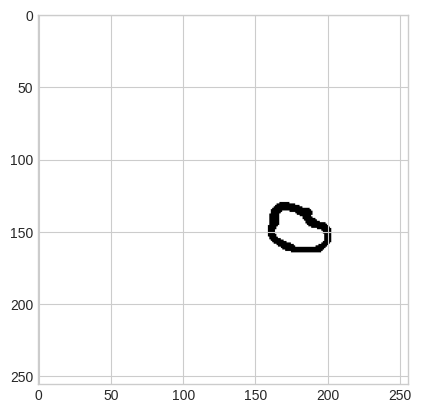

In [25]:
# Create a cubic structuring element
# structure = np.ones((kernel_size, kernel_size, kernel_size), dtype=np.uint8)
structure = spherical_kernel(kernel_size=3)

# Perform 3D dilation and erosion
eroded = ndimage.binary_erosion(mask_cube, structure=structure)
mask_original = ndimage.binary_dilation(eroded, structure=structure)

structure = spherical_kernel(kernel_size=10)
dilated = ndimage.binary_dilation(mask_original, structure=structure)
# eroded = ndimage.binary_erosion(mask, structure=structure)

slice_index = dilated.shape[2] // 2
mask_slice = (dilated[:, :, slice_index] * 255).astype(np.uint8)
plt.imshow(mask_slice) 

# Compute the difference (convert boolean arrays to uint8 for subtraction)
# mask_diff = dilated.astype(np.uint8) - eroded.astype(np.uint8)
mask_diff = np.logical_xor(dilated, eroded)

slice_index = mask_diff.shape[2] // 2
# Multiply by 255 to scale the binary mask to full grayscale range
mask_slice = (mask_diff[:, :, slice_index] * 255).astype(np.uint8)
plt.imshow(mask_slice)
# mask_slice = (mask[:, :, slice_index]).astype(np.uint8)
# save_path = os.path.join('/home/joy0921/Desktop/Dataset/MHD-3DIS/SB_tracks/230', 'mask.png')
# cv.imwrite(save_path, mask_slice)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


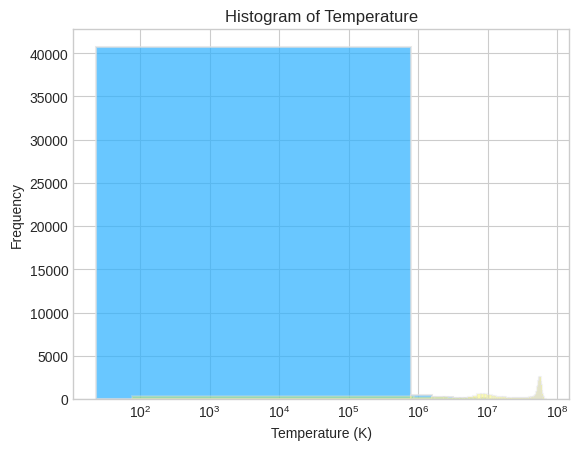

In [27]:
# temp_values = temp_cube[mask_diff == 1]
temp_values = temp_cube[mask_diff == 1]
temp_values_original = temp_cube[eroded == 1]

plt.figure()
plt.hist(temp_values, bins=80, facecolor='#2ab0ff', edgecolor='#e0e0e0', linewidth=1.5, alpha=0.7)      # 2ab0ff
plt.hist(temp_values_original, bins=80, facecolor='#ffff00', edgecolor='#e0e0e0', linewidth=1.5, alpha=0.3)
# Mark a sharp cutoff at 1e4 K
# plt.axvline(x=2500, color='r', linestyle='--', label='Cut off at 1e2 K')

plt.xlabel("Temperature (K)", fontsize=10)
plt.ylabel("Frequency", fontsize=10)
plt.title("Histogram of Temperature", fontsize=12)
# plt.yscale('log')
plt.xscale('log')
# plt.xlim(0, 1e8)
plt.legend()
plt.show()

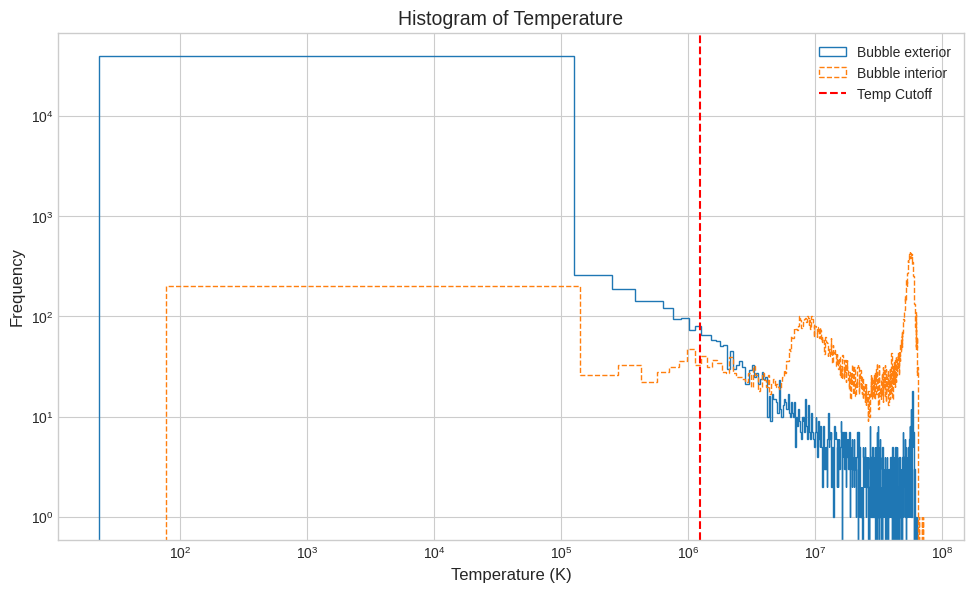

In [31]:
# Use a clean style for the plot
plt.style.use('seaborn-v0_8-whitegrid')     # plt.style.available to check all available style

# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the histogram for the dilated mask temperature values
# ax.hist(temp_values, bins=500, color='#2ab0ff', edgecolor='#e0e0e0', linewidth=1.5, alpha=0.7, label='Dilated Mask')
ax.hist(temp_values, bins=500, histtype='step', linestyle=('solid'), label='Bubble exterior')

# Plot the histogram for the original mask temperature values
# ax.hist(temp_values_original, bins=500, color='#ffff00', edgecolor='#e0e0e0', linewidth=1.5, alpha=0.3, label='Original Mask')
ax.hist(temp_values_original, bins=500, histtype='step', linestyle=('dashed'), label='Bubble interior')

# Mark a sharp cutoff at 1e4 K (optional, uncomment if needed)
ax.axvline(x=temp_values.mean(), color='r', linestyle='--', label='Temp Cutoff')       # 2e7

# Set axis labels and title
ax.set_xlabel("Temperature (K)", fontsize=12)
ax.set_ylabel("Frequency", fontsize=12)
ax.set_title("Histogram of Temperature", fontsize=14)

# Add a legend
ax.legend(fontsize=10)

# Adjust layout for better spacing and show the plot
plt.tight_layout()
plt.xscale('log')
plt.yscale('log')
plt.show()
